In [60]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
import re
from collections import defaultdict

In [79]:
df = pd.read_json('bgg_data_clean.json',orient='split')
df.tail(5)

,year,age,num_players,duration,mechanics,categories,families,num_expansions,num_honors,num_episodes,poll_age,poll_numpl,num_rated,num_comments,rating,bayes_rating,owned
339031,2021,12,"[2, 5]","[50.0, 50.0, 50.0]","[Area Movement, Dice Rolling, Events, Multiple...","[Adventure, Dice, Exploration, Miniatures, Mov...",[Players: One versus Many],1,0,0,"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 2...","[[1, [0, 0, 3]], [2, [1, 2, 0]], [3, [1, 2, 0]...",72,33,8.04653,5.59128,498
339592,2021,10,"[2, 6]","[45.0, 20.0, 45.0]","[Hand Management, Push Your Luck, Set Collecti...","[Animals, Card Game, Party Game]","[Admin: Unreleased Games, Animals: Sheep, Card...",0,0,0,"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 0...","[[1, [0, 0, 0]], [2, [0, 0, 0]], [3, [0, 0, 0]...",31,13,8.83871,5.50032,3
340909,2021,14,"[1, 2]","[30.0, 20.0, 30.0]","[Campaign / Battle Card Driven, Card Play Conf...","[Adventure, Card Game, Fantasy, Print & Play]","[Misc: No Table Needed, Players: Games with So...",0,0,0,"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 0...","[[1, [4, 0, 0]], [2, [0, 2, 2]], [2, [0, 0, 4]]]",51,33,8.55059,5.56187,264
341284,2021,14,"[1, 4]","[120.0, 90.0, 120.0]","[Action/Event, Cooperative Game, Dice Rolling,...","[Dice, Exploration, Fantasy]","[Category: Dungeon Crawler, Players: Games wit...",0,0,0,"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 0...","[[1, [2, 2, 0]], [2, [2, 1, 0]], [3, [0, 2, 0]...",30,4,8.31667,5.53672,91
341530,2021,8,"[1, 6]","[20.0, 20.0, 20.0]",[Pattern Building],[],"[Mechanism: Flip-and-Write, Players: Games wit...",0,0,0,"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 0...","[[1, [0, 1, 0]], [2, [0, 0, 0]], [3, [0, 0, 0]...",32,5,7.29063,5.52952,72


In [67]:
for xs in df['families']:
    for x in xs:
        if ':' not in x:
            print(x)

Fields of Fire Series
Fields of Fire Series
Escape the Room (ThinkFun)
Escape the Room (ThinkFun)
Escape the Room (ThinkFun)


In [77]:
fams = defaultdict(set)
for xs in df['families']:
    for x in xs:
        m = re.match(r'([^:]+):\s*(.*)',x)
        if m:
            fams[m[1]].add(m[2])
        else:
            print(x)
for name,fam in fams.items():
    print(name)
    print(fam)

Fields of Fire Series
Fields of Fire Series
Escape the Room (ThinkFun)
Escape the Room (ThinkFun)
Escape the Room (ThinkFun)
Series
{'Chitpull (Avalanche Press)', 'Great Sieges (Worthington)', 'Play & Go (Thundergryph)', 'Simply Complex line (Capstone Games)', '5 Minute Fun (AEG)', 'Baltic (OSTIA Spiele)', 'Wibbell++ game system', 'Roads through WWII (Hexasim)', 'Napoleonic Wars (GMT)', 'Risk-Like', 'Lynnvander Legacy Line', 'Nürnberger Kuh (NSV)', 'Mysthea', "Lock 'n Load", 'Match the most and win! (Scala leuker leren)', 'Mission Command (Milton Bradley)', 'Good Little (Good Little Games)', 'Standard Combat Series (MMP)', 'Meine erste Spielesammlung (HABA)', 'Chrono Clash System', 'World of Eric Carle (University Games)', 'MOD (Mattel)', 'Great Campaigns of the American Civil War (Avalon Hill/MMP)', "World's Smallest Games Series (Super impulse)", 'Postcard (Button Shy)', 'Q System – Sherlock (GDM Games)', 'Tempus System (Button Shy)', 'Great Battles of the American Civil War (Richard

In [87]:
def collect_attrs(row):
    attrs = set()
    attrs.update(row['categories'])
    attrs.update(row['mechanics'])
    for x in row['families']:
        m = re.match(r'([^:]+):\s*(.*)',x)
        if m:
            if 'Traditional' in x:
                attrs.add('Traditional')
            if m[1] in {'Series','Creatures','Animals','Occupation','History',
                'Food & Drink', 'Rivers', 'Sports Teams', 'Sports', 'Setting', 'Traditional Card Games',
                'Ancient', 'Traditional Games', 'Books', 'Islands', 'Video Game Theme', 'Space',
                'Brands', 'Holidays', 'Religious', 'Characters', 'Toys', 'Medical', 'Fictional Events', 'Music',
                'Historical Figures', 'Celebrities', 'Trivia', 'Decades', 'Political', 'Contests',
                'Traditional Dice Games'
            }:
                attrs.add(m[1])
            elif m[1] in {'Mechanism','Players','Component'}:
                attrs.add(m[2])
            elif m[1] in {'Mythology','Card Games'}:
                attrs.add(m[1])
                attrs.add(f'{m[1]}: {m[2]}')
            elif m[1] in {'Containers','Misc','Category'}:
                attrs.add(f'{m[1]}: {m[2]}')
            elif m[1] in {'TV Shows', 'Movies'}:
                attrs.add('TV, Shows, Movies')
            elif m[1] in {'Comic Books', 'Webcomics', 'Comic Strips'}:
                attrs.add('Comics')
            elif m[1] in {'Region','States','Mountain','Mountains','Cities','Country','Continents'}:
                attrs.add('Region')
            elif m[1] in {'Constructions','Construction'}:
                attrs.add('Construction')
            elif m[1] == 'Folk Tales & Fairy Tales':
                attrs.add('Folk Tales')
            elif m[1] == 'Theme':
                attrs.add('Theme')
                if m[2] in {'Mushrooms','Rivers','Vikings','Nature','Fashion','City','Art','Love / Romance'}:
                    attrs.add(m[2])
                elif m[2] in {'Television (TV) Industry','TV Detectives'}:
                    attrs.add('TV, Shows, Movies')
            elif m[1] == 'Components':
                for x in ['Meeples','Grids','Map','Dice','dice']:
                    if x in m[2]:
                        attrs.add(x)
                        break
                else:
                    attrs.add(m[2])
    return attrs

df['attrs'] = df.apply(collect_attrs, axis=1)

In [88]:
len(df)

23530

In [89]:
all_mechanics = { x for xs in df['mechanics'] for x in xs }
print('N mechanics:',len(all_mechanics))
all_categories = { x for xs in df['categories'] for x in xs }
print('N categories:',len(all_categories))
all_attrs = { x for xs in df['attrs'] for x in xs }
print('N attrs:',len(all_attrs))

N mechanics: 172
N categories: 84
N attrs: 419


In [5]:
num_years, year_min, year_max = [ x for x in df.agg({'year': ['nunique','min','max']})['year'] ]

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

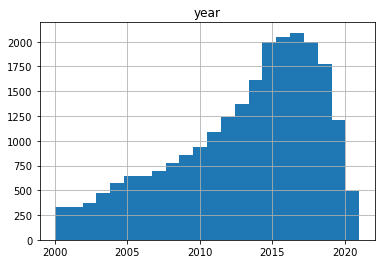

In [6]:
df.hist('year',bins=num_years)

In [7]:
df.groupby('year').agg({'rating': ['mean','std']})

rating          
          mean       std
year                    
2000  6.065747  0.977262
2001  6.037107  0.956571
2002  6.061878  0.901134
2003  6.134391  0.928816
2004  6.207529  0.931080
2005  6.188805  0.953374
2006  6.292386  0.987890
2007  6.321490  0.946897
2008  6.481544  0.869578
2009  6.495533  0.902283
2010  6.606963  0.835785
2011  6.667159  0.861970
2012  6.693297  0.866807
2013  6.778438  0.882061
2014  6.803545  0.854010
2015  6.954063  0.845351
2016  6.981837  0.861326
2017  7.123310  0.818745
2018  7.195908  0.828166
2019  7.329078  0.808763
2020  7.558807  0.732415
2021  7.762349  0.695934

In [8]:
class ScaleRatingByYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.m = {
            key: vals for key,*vals in
            X.groupby('year').agg({'rating':['mean','std']}).to_records()
        }
        return self
    def transform(self, X):
        def scale(x):
            mean, std = self.m[x[0]]
            return (x[1]-mean)/std
        return X[['year','rating']].apply(scale,axis=1)

In [9]:
# scaled_rating = ScaleRatingByYear().fit_transform(df)
df['scaled_rating'] = ScaleRatingByYear().fit_transform(df)
# print(scaled_rating)
# df.groupby('year').agg({'scaled_rating': ['mean','std']})

In [10]:
class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for xs in X:
            yield { x: 1 for x in xs }

In [11]:
binary_encoder = Pipeline([
    ('encode',   DictEncoder()),
    ('vectorize',DictVectorizer(sparse=False))
])
X_all = Pipeline([
    ('attrs',ColumnTransformer([
        ('mechanics',binary_encoder,'mechanics'),
        ('categories',binary_encoder,'categories')
    ]))
]).fit_transform(df)
X_all

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
y_all = df['scaled_rating'].to_numpy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.35, random_state=123)

In [14]:
model = Pipeline([
    ('PCA',PCA(n_components=2))
])
# model.fit(X_train)
X_pca = model.fit_transform(X_train)

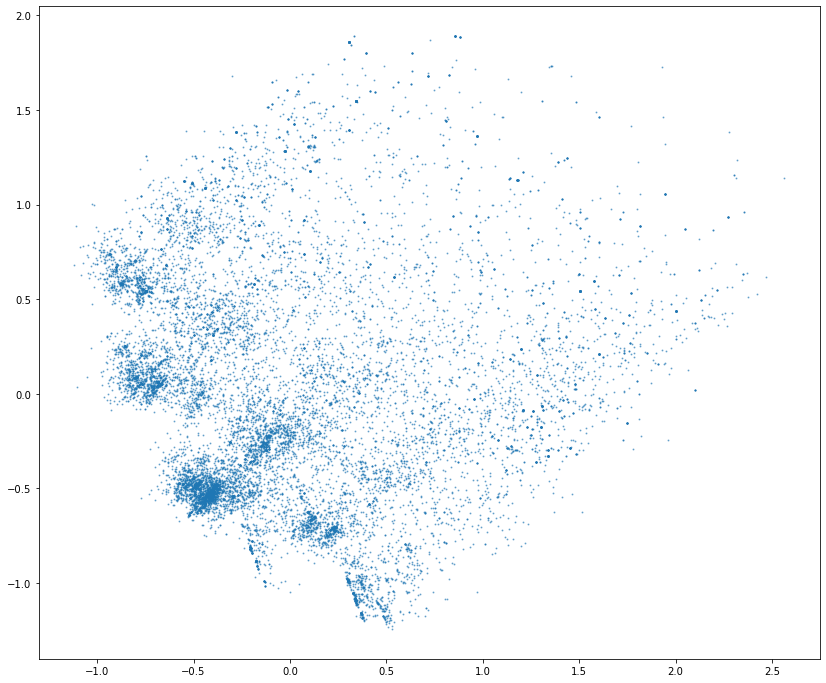

In [17]:
plt.gcf().set_size_inches(14,12)
plt.scatter(X_pca[:,0], X_pca[:,1], s=1, alpha=0.5)

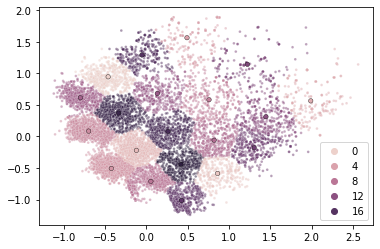

In [18]:
km = KMeans(n_clusters=20)
km.fit(X_pca)

ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=km.labels_, alpha=0.5, s=7)
ax = sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:, 1],
                     hue=range(km.n_clusters), s=20, ec='black', legend=False, ax=ax)

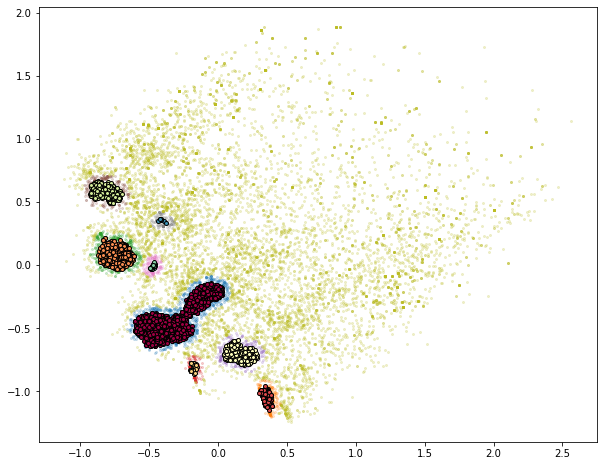

In [59]:
db = DBSCAN(eps=0.06,min_samples=100)
db.fit(X_pca)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

plt.gcf().set_size_inches(10,8)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)

    xy = X_pca[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=4, alpha=0.2)